In [3]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


Importando bibliotecas

In [4]:
!pip -q install tensorflow tensorflow-hub annoy pandas pillow tqdm opencv-python flask streamlit

import os
from pathlib import Path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 106.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 110.4 MB/s eta 0:00:00


Configurando o caminho onde as imagens ficarão

In [5]:
# =========================
# 0) SETUP / INSTALL
# =========================


ROOT = Path(".")
DATA_DIR = ROOT / "data"
IMG_DIR  = DATA_DIR / "images"          # imagens (jpg/png)
META_CSV = DATA_DIR / "metadata.csv"    # metadados (opcional)

ARTIFACTS = ROOT / "artifacts"
EMB_DIR   = ARTIFACTS / "embeddings"    # embeddings salvos por imagem
INDEX_DIR = ARTIFACTS / "index"         # dicionários + annoy index + configs

for p in [DATA_DIR, IMG_DIR, ARTIFACTS, EMB_DIR, INDEX_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Pastas OK:", IMG_DIR, EMB_DIR, INDEX_DIR)

Pastas OK: data/images artifacts/embeddings artifacts/index


Acesso ao google

Criação de pastas no Drive

In [6]:
from pathlib import Path

# nome da pasta principal
PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")

DATA_DIR = PROJECT_DIR / "data"
IMG_DIR  = DATA_DIR / "images"
ARTIFACTS = PROJECT_DIR / "artifacts"
EMB_DIR   = ARTIFACTS / "embeddings"
INDEX_DIR = ARTIFACTS / "index"

for p in [DATA_DIR, IMG_DIR, ARTIFACTS, EMB_DIR, INDEX_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("✅ Projeto:", PROJECT_DIR)
print("✅ Coloque suas imagens em:", IMG_DIR)
print("✅ Embeddings serão salvos em:", EMB_DIR)
print("✅ Índice será salvo em:", INDEX_DIR)


✅ Projeto: /content/drive/MyDrive/reco_similares
✅ Coloque suas imagens em: /content/drive/MyDrive/reco_similares/data/images
✅ Embeddings serão salvos em: /content/drive/MyDrive/reco_similares/artifacts/embeddings
✅ Índice será salvo em: /content/drive/MyDrive/reco_similares/artifacts/index


verificando se a GPU está visível

In [7]:
import tensorflow as tf
print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Biblioteca para baixar arquivos do kaggle

In [8]:
!pip -q install kaggle


Faz upload do arquivo kaggle.json do kaggle no colab


In [9]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"renatojustino","key":"8bcae38f18a5d30bb00900e50bf6343e"}'}

Move o kaggle.json para o lugar correto e ajustar permissão

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Apenas uma conferência se está tudo conforme ajustado

In [11]:
!kaggle datasets list -s fashion-product-images-small | head


ref                                                         title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
paramaggarwal/fashion-product-images-small                  Fashion Product Images (Small)                      592614936  2019-04-26 16:33:51.490000          63451        443  1.0              
kuchhbhi/stylish-product-image-dataset                      Stylish Product Image Dataset                      9509715613  2022-05-21 15:37:19.960000           1407         48  0.9411765        
paramaggarwal/fashion-product-images-dataset                Fashion Product Images Dataset                    24771215740  2019-03-14 18:57:43.307000          68196        807  1.0              
promptcloud/amazon-fashio

Baixar o dataset (Fashion Product Images – Small)

In [12]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small


Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 97% 547M/565M [00:03<00:00, 86.6MB/s]
100% 565M/565M [00:03<00:00, 181MB/s] 


Extrai o dataset (Fashion Product Images – Small)

In [13]:
!unzip -q fashion-product-images-small.zip -d fashion_dataset


Validação se os dados realmente subiram

In [14]:
!ls fashion_dataset | head
!ls fashion_dataset/images | head

images
myntradataset
styles.csv
10000.jpg
10001.jpg
10002.jpg
10003.jpg
10004.jpg
10005.jpg
10006.jpg
10007.jpg
10008.jpg
10009.jpg


In [15]:
import pandas as pd
import shutil
from pathlib import Path

# =============================
# CAMINHOS
# =============================
PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_OUT = PROJECT_DIR / "data/images"

DATASET_DIR = Path("/content/fashion_dataset")
IMAGES_SRC = DATASET_DIR / "images"
META = pd.read_csv(DATASET_DIR / "styles.csv", on_bad_lines="skip")

# =============================
# DEFINIÇÃO DOS 4 ITENS (articleType)
# =============================
TARGETS = {
    "camisetas": ["Tshirts", "Shirts"],
    "tenis": ["Sneakers", "Casual Shoes", "Sports Shoes"],
    "calcas": ["Jeans", "Trousers", "Track Pants"],
    "bolsas": ["Handbags", "Backpacks", "Clutches", "Wallets"]
}

MAX_PER_CLASS = 50

# cria pastas
for folder in TARGETS.keys():
    (IMG_OUT / folder).mkdir(parents=True, exist_ok=True)

# valida coluna
if "articleType" not in META.columns:
    raise ValueError("Não encontrei a coluna 'articleType' no styles.csv. Rode o diagnóstico do Passo 3A.")

# mostra quantos candidatos existem por classe
print("Candidatos no dataset (articleType):")
for folder, types in TARGETS.items():
    n = META[META["articleType"].isin(types)].shape[0]
    print(f"  {folder}: {n} candidatos")

count = {k: 0 for k in TARGETS.keys()}

# copia
for _, row in META.iterrows():
    art = row.get("articleType")
    img_id = row.get("id")

    # pula ids faltantes
    if pd.isna(img_id):
        continue

    # decide destino
    dest_folder = None
    for folder, types in TARGETS.items():
        if art in types and count[folder] < MAX_PER_CLASS:
            dest_folder = folder
            break

    if dest_folder is None:
        continue

    src = IMAGES_SRC / f"{int(img_id)}.jpg"
    dst = IMG_OUT / dest_folder / f"{int(img_id)}.jpg"

    if src.exists():
        shutil.copy(src, dst)
        count[dest_folder] += 1

    if all(v >= MAX_PER_CLASS for v in count.values()):
        break

print("\n✅ Resultado final:")
for k, v in count.items():
    print(f"{k}: {v} imagens")


Candidatos no dataset (articleType):
  camisetas: 10284 candidatos
  tenis: 4881 candidatos
  calcas: 1443 candidatos
  bolsas: 3709 candidatos

✅ Resultado final:
camisetas: 50 imagens
tenis: 50 imagens
calcas: 50 imagens
bolsas: 50 imagens


In [16]:
!ls /content/drive/MyDrive/reco_similares/data/images


bolsas	calcas	camisetas  tenis


Conferência se a quantidade de imagens estão exatamente nas pastas que foram criada (camisetas , tenis, calcas  e bolsas)

In [17]:
!ls /content/drive/MyDrive/reco_similares/data/images/camisetas | wc -l
!ls /content/drive/MyDrive/reco_similares/data/images/tenis | wc -l
!ls /content/drive/MyDrive/reco_similares/data/images/calcas | wc -l
!ls /content/drive/MyDrive/reco_similares/data/images/bolsas | wc -l


50
50
50
50


# Etapa 4: Metadados e Indexação

Gera o metadados

In [18]:
import pandas as pd
from pathlib import Path

# =============================
# CAMINHOS DO PROJETO
# =============================
PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"
META_PATH = PROJECT_DIR / "data/metadata.csv"

records = []
image_id = 0

# =============================
# VARREDURA DAS IMAGENS
# =============================
for item_dir in sorted(IMG_DIR.iterdir()):
    if not item_dir.is_dir():
        continue

    item_name = item_dir.name

    for img_path in sorted(item_dir.glob("*.jpg")):
        records.append({
            "image_id": image_id,
            "item": item_name,
            "image_path": str(img_path.relative_to(IMG_DIR)),
            "filename": img_path.name
        })
        image_id += 1

# =============================
# CRIA DATAFRAME
# =============================
df_meta = pd.DataFrame(records)

# =============================
# SALVA CSV
# =============================
df_meta.to_csv(META_PATH, index=False)

print("✅ metadata.csv criado com sucesso!")
print("Total de imagens:", len(df_meta))
display(df_meta.head())


✅ metadata.csv criado com sucesso!
Total de imagens: 200


,image_id,item,image_path,filename
0,0,bolsas,bolsas/12732.jpg,12732.jpg
1,1,bolsas,bolsas/14851.jpg,14851.jpg
2,2,bolsas,bolsas/14856.jpg,14856.jpg
3,3,bolsas,bolsas/14869.jpg,14869.jpg
4,4,bolsas,bolsas/17081.jpg,17081.jpg


Conferindo se realmente retornou com a estnsão metadata.csv

In [19]:
!ls /content/drive/MyDrive/reco_similares/data

images	metadata.csv


In [20]:
!wc -l /content/drive/MyDrive/reco_similares/data/metadata.csv


201 /content/drive/MyDrive/reco_similares/data/metadata.csv


# Etapa 5: Testes locais

Instalando a biblioteca pillow

In [21]:
!pip -q install tensorflow tensorflow-hub pillow

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
from pathlib import Path

# =============================
# CONFIGURAÇÕES
# =============================
IMG_SIZE = 224
EMBEDDING_DIM = 512

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"

# =============================
# CONSTRÓI O ENCODER
# =============================
def build_bit_encoder():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)

    # normalização
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # BiT backbone
    x = hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r50x3/1",
        trainable=False
    )(x)

    # garante vetor
    if len(x.shape) == 4:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # camada de embedding
    x = tf.keras.layers.Dense(EMBEDDING_DIM, activation=None)(x)

    # normalização L2 (importante para similaridade)
    x = tf.keras.layers.Lambda(
        lambda t: tf.math.l2_normalize(t, axis=1)
    )(x)

    return tf.keras.Model(inputs, x, name="bit_encoder")

encoder = build_bit_encoder()
encoder.summary()


Alinha as versões do tensorflow

In [22]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

!pip -q install -U "tensorflow==2.19.0" "tf_keras==2.19.0" "tensorflow-hub==0.16.1"



Seleciona a GPU e reinicia a ssssão

In [23]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import tensorflow as tf

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices("GPU"))


TF: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


encoder BiT

In [40]:
!pip -q install -U tf_keras==2.19.0 tensorflow-hub==0.16.1


# Reinicie a sessão (Runtime → Restart session)
## Isso é obrigatório para limpar os imports.

##Após isso siga o fluxo do código.

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"




In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras  # <<< IMPORTANTE: usar tf_keras (Keras 2)
import numpy as np

IMG_SIZE = 224
EMBEDDING_DIM = 512

def build_bit_encoder():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)

    x = keras.layers.Rescaling(1./255)(inputs)

    # BiT backbone
    x = hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r50x3/1",
        trainable=False
    )(x)

    # Se vier 4D, faz pooling
    if len(x.shape) == 4:
        x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(EMBEDDING_DIM, activation=None)(x)

    # L2 normalize
    x = keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    model = keras.Model(inputs, x, name="bit_encoder")
    return model

encoder = build_bit_encoder()
encoder.summary()


Model: "bit_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dense (Dense)               (None, 512)               3146240   
                                                                 
 lambda (Lambda)             (None, 512)               0         
                                                                 
Total params: 214320320 (817.57 MB)
Trainable params: 3146240 (12.00 MB)
Non-trainable params: 211174080 (805.57 MB)
_________________________________________________________________


In [4]:
x = np.zeros((1, 224, 224, 3), dtype=np.float32)
y = encoder(x, training=False).numpy()
print("OK:", y.shape, "norma:", np.linalg.norm(y))


OK: (1, 512) norma: 0.99999994


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image
from pathlib import Path

# =============================
# CONFIGURAÇÕES
# =============================
IMG_SIZE = 224
EMBEDDING_DIM = 512

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"

# =============================
# CONSTRÓI O ENCODER
# =============================
def build_bit_encoder():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32)

    # normalização
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    # BiT backbone
    x = hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r50x3/1",
        trainable=False
    )(x)

    # garante vetor
    if len(x.shape) == 4:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # camada de embedding
    x = tf.keras.layers.Dense(EMBEDDING_DIM, activation=None)(x)

    # normalização L2 (importante para similaridade)
    x = tf.keras.layers.Lambda(
        lambda t: tf.math.l2_normalize(t, axis=1)
    )(x)

    return tf.keras.Model(inputs, x, name="bit_encoder")

encoder = build_bit_encoder()
encoder.summary()


Model: "bit_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 6144)              211174080 
                                                                 
 dense_1 (Dense)             (None, 512)               3146240   
                                                                 
 lambda_1 (Lambda)           (None, 512)               0         
                                                                 
Total params: 214320320 (817.57 MB)
Trainable params: 3146240 (12.00 MB)
Non-trainable params: 211174080 (805.57 MB)
_________________________________________________________________


# Etapa 6 — Gerar embeddings para TODAS as imagens (200)

In [6]:
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# =============================
# CONFIGURAÇÕES
# =============================
IMG_SIZE = 224
EMBEDDING_DIM = 512

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"
META_PATH = PROJECT_DIR / "data/metadata.csv"
EMB_DIR = PROJECT_DIR / "artifacts/embeddings"

EMB_DIR.mkdir(parents=True, exist_ok=True)

# =============================
# CARREGA METADATA
# =============================
df = pd.read_csv(META_PATH)

print("Total de imagens:", len(df))

# =============================
# FUNÇÃO DE LEITURA
# =============================
def load_image(path: Path):
    img = Image.open(path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32)
    return np.expand_dims(arr, axis=0)

# =============================
# GERA EMBEDDINGS
# =============================
embeddings = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = IMG_DIR / row["image_path"]
    x = load_image(img_path)

    emb = encoder(x, training=False).numpy().squeeze()
    embeddings.append(emb)

    # salva individualmente (robusto)
    np.save(EMB_DIR / f"{row['image_id']}.npy", emb)

# =============================
# SALVA MATRIZ COMPLETA
# =============================
embeddings = np.vstack(embeddings)
np.save(EMB_DIR / "embeddings_all.npy", embeddings)

print("✅ Embeddings gerados!")
print("Shape final:", embeddings.shape)


Total de imagens: 200


100%|██████████| 200/200 [00:21<00:00,  9.44it/s]

✅ Embeddings gerados!
Shape final: (200, 512)


Cobferência do embeddings

In [7]:
!ls /content/drive/MyDrive/reco_similares/artifacts/embeddings | head


0.npy
100.npy
101.npy
102.npy
103.npy
104.npy
105.npy
106.npy
107.npy
108.npy


In [8]:
import numpy as np

emb = np.load("/content/drive/MyDrive/reco_similares/artifacts/embeddings/0.npy")
print("Dimensão do embedding:", emb.shape)
print("Norma L2:", np.linalg.norm(emb))


Dimensão do embedding: (512,)
Norma L2: 0.99999994


# Etapa 7 — Criar o índice Annoy + recomendar produtos similares


Cria o índice Annoy

In [9]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
from pathlib import Path

# =============================
# CONFIGURAÇÕES
# =============================
EMBEDDING_DIM = 512
N_TREES = 50  # bom equilíbrio precisão x velocidade

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
EMB_DIR = PROJECT_DIR / "artifacts/embeddings"
META_PATH = PROJECT_DIR / "data/metadata.csv"
INDEX_DIR = PROJECT_DIR / "artifacts/index"

INDEX_DIR.mkdir(parents=True, exist_ok=True)

# =============================
# CARREGA DADOS
# =============================
df = pd.read_csv(META_PATH)

# =============================
# CRIA ÍNDICE
# =============================
annoy_index = AnnoyIndex(EMBEDDING_DIM, metric="angular")

for _, row in df.iterrows():
    emb = np.load(EMB_DIR / f"{row['image_id']}.npy")
    annoy_index.add_item(int(row["image_id"]), emb)

print("🔨 Construindo índice Annoy...")
annoy_index.build(N_TREES)

# =============================
# SALVA ÍNDICE
# =============================
annoy_index.save(str(INDEX_DIR / "products.ann"))

print("✅ Índice Annoy criado e salvo!")


🔨 Construindo índice Annoy...
✅ Índice Annoy criado e salvo!


Primeira recomendação real (Top-K)

🔎 Imagem consulta:
image_id                    87
item                    calcas
image_path    calcas/39386.jpg
filename             39386.jpg
Name: 87, dtype: object

Itens similares: [87, 63, 88, 64, 86, 101]
Distâncias: [0.0, 0.40276187658309937, 0.4676817059516907, 0.4807283282279968, 0.500043511390686, 0.5588120222091675]


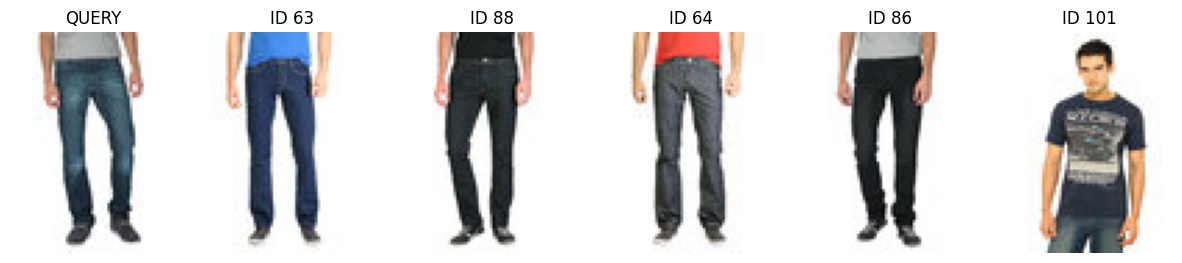

In [10]:
from annoy import AnnoyIndex
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

# =============================
# CONFIGURAÇÕES
# =============================
EMBEDDING_DIM = 512
TOP_K = 6

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"
META_PATH = PROJECT_DIR / "data/metadata.csv"
INDEX_PATH = PROJECT_DIR / "artifacts/index/products.ann"

# =============================
# CARREGA METADATA E ÍNDICE
# =============================
df = pd.read_csv(META_PATH)

annoy_index = AnnoyIndex(EMBEDDING_DIM, metric="angular")
annoy_index.load(str(INDEX_PATH))

# =============================
# ESCOLHE IMAGEM DE CONSULTA
# =============================
query_id = random.choice(df["image_id"].tolist())
query_row = df[df["image_id"] == query_id].iloc[0]

print("🔎 Imagem consulta:")
print(query_row)

# =============================
# BUSCA SIMILARES
# =============================
ids, distances = annoy_index.get_nns_by_item(
    query_id,
    TOP_K,
    include_distances=True
)

print("\nItens similares:", ids)
print("Distâncias:", distances)

# =============================
# VISUALIZAÇÃO
# =============================
plt.figure(figsize=(15, 4))

for i, img_id in enumerate(ids):
    row = df[df["image_id"] == img_id].iloc[0]
    img_path = IMG_DIR / row["image_path"]

    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, TOP_K, i + 1)
    plt.imshow(img)
    plt.axis("off")

    label = "QUERY" if img_id == query_id else f"ID {img_id}"
    plt.title(label)

plt.show()


Recomendação a partir de imagem LOCAL

Upload da imagem local

In [11]:
from google.colab import files

uploaded = files.upload()


Saving tenis_teste.jpg to tenis_teste.jpg


Gerar recomendação para a imagem externa

Imagem carregada: /content/tenis_teste.jpg
Embedding gerado: (512,)
IDs recomendados: [182, 153, 178, 189, 198, 199]
Distâncias: [0.7731561660766602, 0.7846975326538086, 0.7935073375701904, 0.807608962059021, 0.825042724609375, 0.8447036743164062]


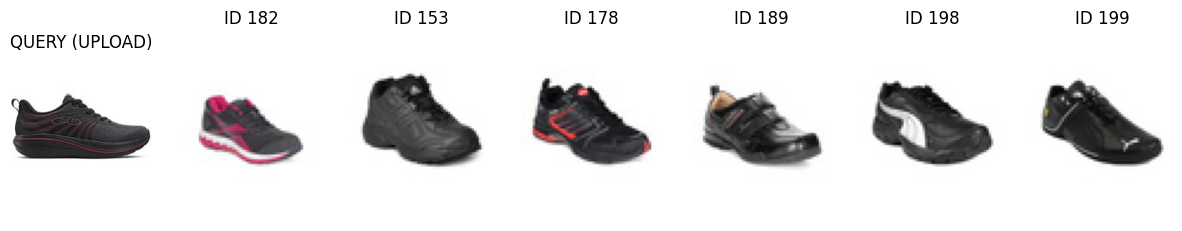

In [12]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from annoy import AnnoyIndex

# =============================
# CONFIGURAÇÕES
# =============================
IMG_SIZE = 224
EMBEDDING_DIM = 512
TOP_K = 6

PROJECT_DIR = Path("/content/drive/MyDrive/reco_similares")
IMG_DIR = PROJECT_DIR / "data/images"
META_PATH = PROJECT_DIR / "data/metadata.csv"
INDEX_PATH = PROJECT_DIR / "artifacts/index/products.ann"

# =============================
# CARREGA METADATA E ÍNDICE
# =============================
df = pd.read_csv(META_PATH)

annoy_index = AnnoyIndex(EMBEDDING_DIM, metric="angular")
annoy_index.load(str(INDEX_PATH))

# =============================
# IDENTIFICA IMAGEM UPLOAD
# =============================
uploaded_img_name = list(uploaded.keys())[0]
uploaded_img_path = Path("/content") / uploaded_img_name

print("Imagem carregada:", uploaded_img_path)

# =============================
# PREPROCESSAMENTO
# =============================
img = Image.open(uploaded_img_path).convert("RGB")
img = img.resize((IMG_SIZE, IMG_SIZE))

x = np.expand_dims(np.array(img).astype(np.float32), axis=0)

# =============================
# GERA EMBEDDING
# =============================
query_embedding = encoder(x, training=False).numpy().squeeze()

print("Embedding gerado:", query_embedding.shape)

# =============================
# BUSCA SIMILARES
# =============================
ids, distances = annoy_index.get_nns_by_vector(
    query_embedding,
    TOP_K,
    include_distances=True
)

print("IDs recomendados:", ids)
print("Distâncias:", distances)

# =============================
# VISUALIZAÇÃO
# =============================
plt.figure(figsize=(15, 4))

# imagem de consulta
plt.subplot(1, TOP_K + 1, 1)
plt.imshow(img)
plt.axis("off")
plt.title("QUERY (UPLOAD)")

# recomendações
for i, img_id in enumerate(ids):
    row = df[df["image_id"] == img_id].iloc[0]
    rec_path = IMG_DIR / row["image_path"]

    rec_img = Image.open(rec_path).convert("RGB")
    plt.subplot(1, TOP_K + 1, i + 2)
    plt.imshow(rec_img)
    plt.axis("off")
    plt.title(f"ID {img_id}")

plt.show()
